# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

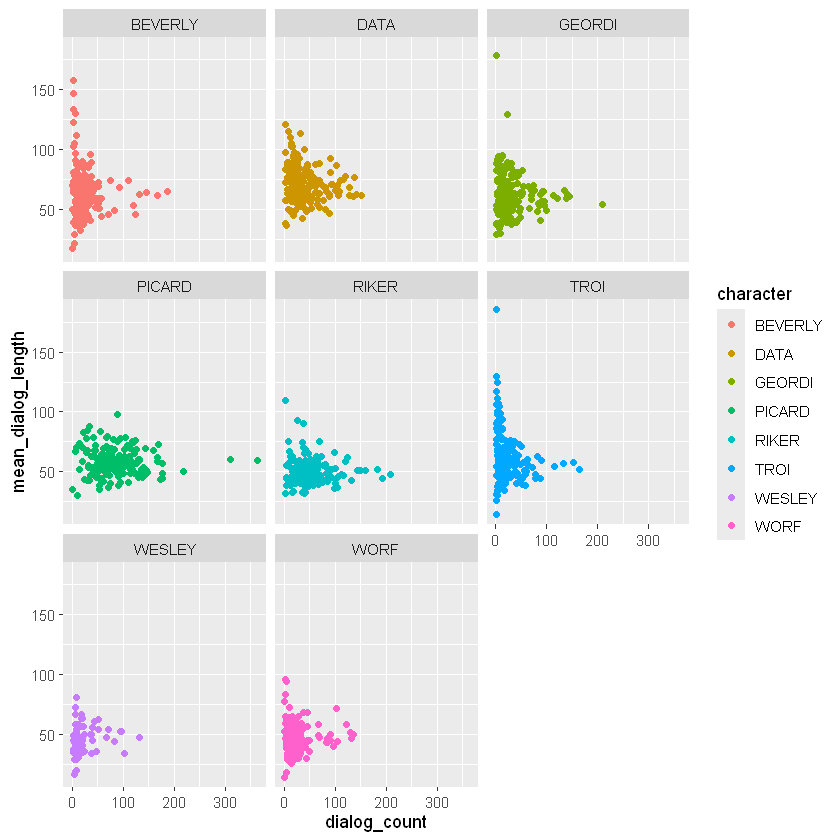

In [2]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

These graphs demonstrate the ratios of dialog length to dialog count. We can see that some characters have fewer, longer dialogues (e.g., Troi), while others have more short dialogues (e.g., Picard). These graphs can demonstrate how some characters may be prominent, but have less depth because they speak frequently but not for long. Meanwhile, characters who have fewer long dialogues might fit the sage archetype. Characters who have both long and frequent dialogues are likely main characters in the show. Characters who do not have many dialogues or long dialogues are likely not prominent characters in the show. 

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`. 
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season. 

In [27]:
beverly<- dialog_len_per_ep %>%
    filter(character=="BEVERLY",  episode_number >= 102 & episode_number <= 126 | episode_number >= 149 & episode_number <= 174) %>%
    mutate(season = case_when(
    episode_number >= 102 & episode_number <= 126 ~ "Season 1",
    episode_number >= 149 & episode_number <= 174 ~ "Season 3")) %>%
    group_by(season, episode_number) %>% 
    summarize(mean_dialog_length, dialog_count, .groups="drop") %>%
    group_by(season) %>%
    summarize(mean(mean_dialog_length), mean(dialog_count), .groups="drop")
beverly

season,mean(mean_dialog_length),mean(dialog_count)
<chr>,<dbl>,<dbl>
Season 1,56.48460,25.40
Season 3,67.04817,19.64


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

This change is reflected in a longer dialogue length and fewer instances of dialogues in season 3. These changes made her feel more like a male character because her character was given more depth. 

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character. 
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [28]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [35]:
tokens <- dialogs_fixed %>%
  # Split each dialog into words
  mutate(word_list = str_split(dialog, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% stop_words)

head(tokens)

episode_number,character,dialog,dialog_length,word_list,word
<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Captain's,captains
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"log,",log
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,stardate,stardate
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,42353.7.,423537
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,destination,destination
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,planet,planet


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [39]:
unique_words <- tokens %>%
    group_by(character) %>%
    summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocabulary_richness = unique_words / total_words
  ) %>%
  arrange(desc(vocabulary_richness))

head(unique_words)

character,total_words,unique_words,vocabulary_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7601,2291,0.3014077
WORF,18820,4318,0.2294368
TROI,19450,4187,0.2152699
BEVERLY,22900,4875,0.2128821
DATA,45462,8593,0.1890150
GEORDI,31978,5465,0.1708987


#### c) Plot total words versus vocab richness. 
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

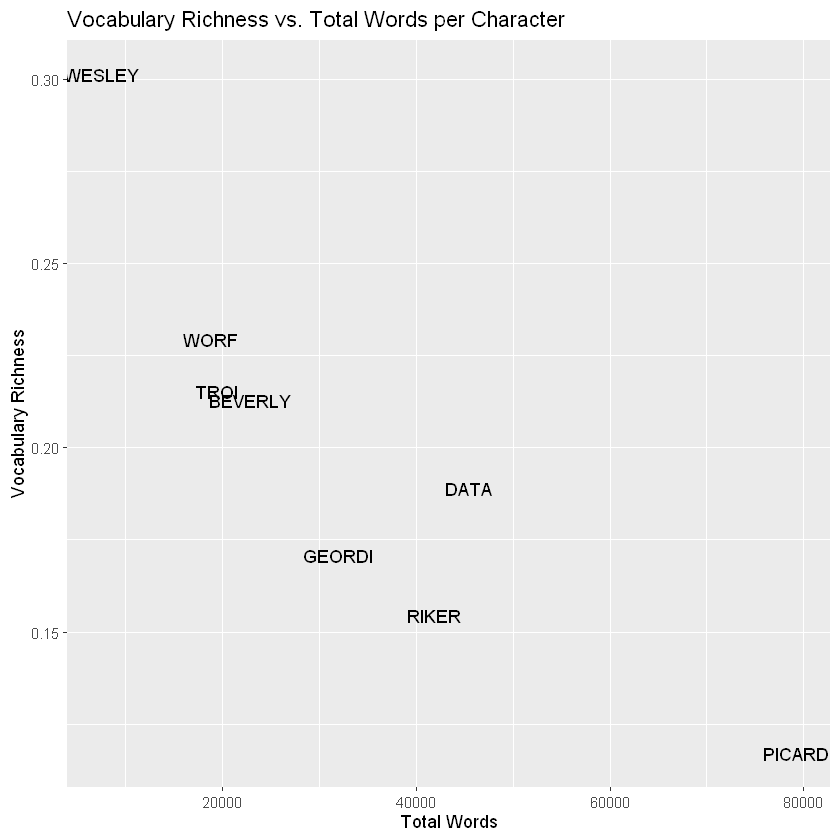

In [43]:
ggplot(unique_words, aes(x = total_words, y = vocabulary_richness, label = character)) +
  geom_text() +
  labs(
    title = "Vocabulary Richness vs. Total Words per Character",
    x = "Total Words",
    y = "Vocabulary Richness"
  ) +
  theme(legend.position = "none")

#### d) Interpret these results. 

These results demonstrate that as total words increase, vocabulary richness decreases for the most part. Characters like Worf, Troi, and Beverly have a lower total word count, but their vocabularies are richer. On the other hand, Picard has a high word count, but a very low vocabulary richness. These results imply that Worf, Troi, and Beverly may have more depth as characters, while Picard seems to be a prominent yet unidimensional character. 

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row. 
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap. 

In [49]:
wesley<- dialog_len_per_ep %>%
    filter(character=="WESLEY", episode_number > 174) %>%
    arrange(episode_number)
wesley

character,episode_number,mean_dialog_length,dialog_count
<chr>,<dbl>,<dbl>,<int>
WESLEY,175,36.38889,18
WESLEY,176,66.50000,6
WESLEY,177,53.55556,9
WESLEY,178,18.66667,6
WESLEY,179,49.97368,38
WESLEY,181,45.00000,2
WESLEY,183,52.17021,94
WESLEY,206,46.90076,131
WESLEY,219,53.56338,71


Wesley left the show as a main character after episode 183. 

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

Wesley makes cameo appearances in episodes 206, 219, 263, and 272 after he left the show as a main character following episode 183. 

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [58]:
wesley_dialog_main <- dialogs_fixed %>%
    filter(character=="WESLEY", episode_number == 183)%>%
    slice_tail(n=1)
wesley_dialog_main

episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
183,WESLEY,I can walk.,11


In [59]:
wesley_dialog_last <- dialogs_fixed %>%
    filter(character=="WESLEY", episode_number == 272)%>%
    slice_tail(n=1)
wesley_dialog_last

episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
272,WESLEY,"Good-bye, Mom.",14


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title. 
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

In [67]:
character_means <- dialog_len_per_ep %>%
    group_by(character) %>%
    summarize(mean=mean(mean_dialog_length)) %>%
    arrange(mean) %>%
    pull(character)

character_means

[1] "WESLEY"  "WORF"    "RIKER"   "PICARD"  "TROI"    "GEORDI"  "BEVERLY"
[8] "DATA"

In [72]:
heatmap <- dialog_len_per_ep %>%
    mutate(character= factor(character, levels = character_means))
head(heatmap)

character,episode_number,mean_dialog_length,dialog_count
<fct>,<dbl>,<dbl>,<int>
TROI,129,185.5000,2
GEORDI,249,179.0000,1
BEVERLY,242,158.0000,2
BEVERLY,159,146.5000,2
BEVERLY,261,133.5000,2
BEVERLY,116,129.7143,7


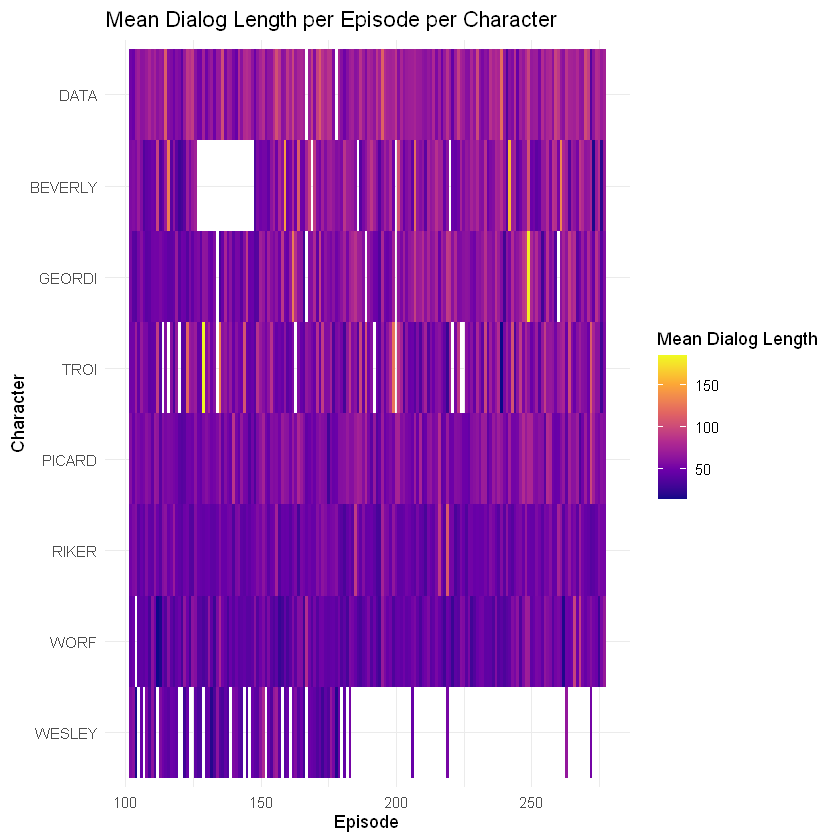

In [75]:

ggplot(heatmap, aes(x=episode_number, y=character, fill=mean_dialog_length)) +
    geom_tile() +
    scale_fill_viridis_c(option = "plasma", name = "Mean Dialog Length") + 
  labs(
    title = "Mean Dialog Length per Episode per Character",
    x = "Episode",
    y = "Character"
  ) +
  theme_minimal()